In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *
from sensetools.plots import feature_labeller

In [2]:
from scipy.stats import spearmanr
from collections import defaultdict

In [3]:
protein = '1fme'

In [4]:
summary_paths = [f'../{protein}/summary_batch1.h5', f'../{protein}/summary_batch2.h5']
vamp_eqs = []
for summary_path in summary_paths:
    vamp_eqs.append(pd.read_hdf(summary_path, key='vamp_eqs'))
vamp_eqs = pd.concat(vamp_eqs)
# vamp_eqs.reset_index(inplace=True)

In [5]:
vamp_eqs['rank'] = vamp_eqs.groupby(['lag', 'process'])['median'].rank(ascending=False)

In [6]:
def spearmans(df: pd.DataFrame, proc: int, top: int = 95) -> pd.DataFrame: 
    lags = df.lag.unique()
    n_lags = len(lags)
    results = defaultdict(list)
    if top == -1: 
        top = df['rank'].max()
        
    for i in range(n_lags):
        i_lag = lags[i]
        i_keep_ix = df.loc[(df['rank'] <= top) & (df.lag == i_lag) & (df.process == proc), 'hp_ix'].values
        ps = []
        for j in range(n_lags): 
            i_lag, j_lag = lags[i], lags[j]
            
            j_keep_ix = df.loc[(df.lag == j_lag) & (df.process == proc), 'hp_ix']
            keep_ix = set(i_keep_ix).intersection(set(j_keep_ix))
            
            a = df.loc[(df.lag == i_lag) & (df.process == proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
            b = df.loc[(df.lag == j_lag) & (df.process == proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
#             print(len(a), len(b))
            r, p = spearmanr(a, b)
            ps.append(p)
            results['i_lag'].append(i_lag)
            results['j_lag'].append(j_lag)
            results['r'].append(r)
#         print(np.mean(p)>0.05)
    df = pd.DataFrame(results)
    df = df.pivot_table(values='r', index='i_lag', columns='j_lag')
    return df

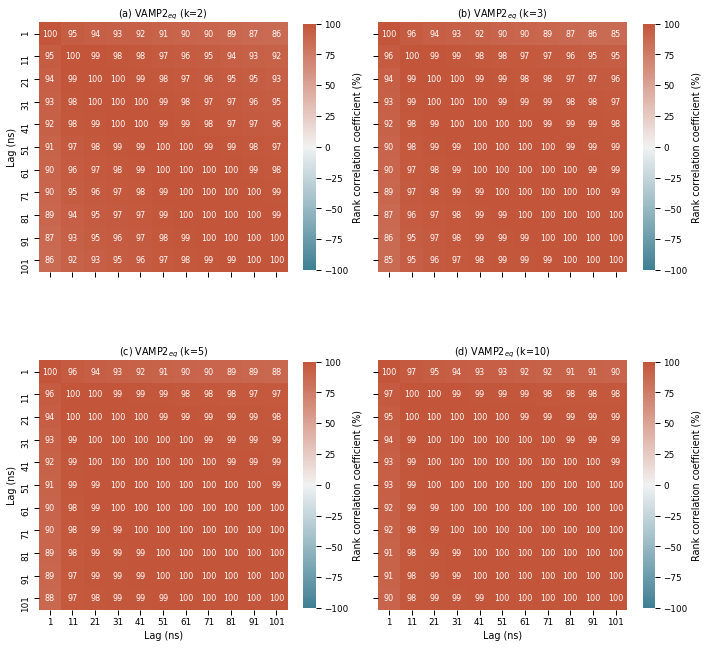

In [7]:
with sns.plotting_context('paper', font_scale=1):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    
    procs = [2, 3, 5, 10]
    top_n = -1
    for i in range(2):
        for j in range(2):
            ax = axes[i, j]
            proc = np.reshape(procs, axes.shape)[i, j]
            df = spearmans(vamp_eqs, proc, top_n)
            

            sns.heatmap(df*100, ax=ax, vmin=-100, vmax=100, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), cbar=True, 
                        annot_kws=dict(size='small'), square=True, fmt='2.0f', 
                        cbar_kws=dict(shrink=0.7, label='Rank correlation coefficient (%)'))
            if i == 1:
                ax.set_xlabel('Lag (ns)')
            else: 
                ax.set_xlabel('')
            if j == 0: 
                ax.set_ylabel('Lag (ns)')
            else: 
                ax.set_ylabel('')
            ax.set_title(f"({list('abcd')[i*2+j]}) VAMP2$_{{eq}}$ (k={proc})")
                
    plt.tight_layout()
    plt.savefig(f'../{protein}/vampeq_rank_vs_lag.pdf', bbox_inches='tight')

In [8]:
for proc in procs: 
    df = vamp_eqs.loc[(vamp_eqs.process == proc), ['rank', 'lag', 'hp_ix']]
    lags = np.sort(df.lag.unique())
    col_vars = [fr"Rank ($\tau={x}$)" for x in lags]
    df['lag'] = df['lag'].apply(lambda x: fr"Rank ($\tau={x}$)")
    
    with sns.plotting_context('paper', font_scale=2): 
        sns.pairplot(df.pivot(index='hp_ix', columns='lag', values='rank'), vars=col_vars, corner=True,diag_kind=None)
        
        plt.savefig(f'../{protein}/vampeq_rank_vs_lag_pairplot_k{proc}.pdf', bbox_inches='tight')      
        plt.close()